In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div, factorial
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
from scipy.optimize import minimize
import scipy.stats as sts
from tqdm import tqdm
import itertools


from JDFLOW.intensity_optimization import *
from JDFLOW.signature_computation import *
from JDFLOW.stochastic_processes import *
from JDFLOW.nsde_functions import *
from JDFLOW.nsde_solvers import *
from JDFLOW.jdflow import *
from JDFLOW.evaluate.metrics import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
data = pd.read_csv('Data/gen.us.txt')['Close'].values
data2 = pd.read_csv('Data/amzn.us.txt')['Close'].values

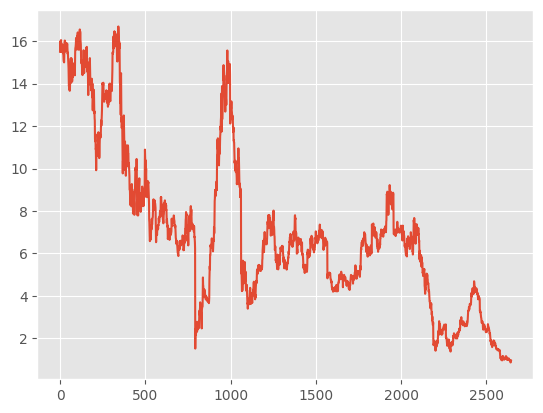

In [3]:
plt.plot(data)
# plt.plot(data2)

plt.show()

In [4]:
data = np.log1p(data)
data2 = np.log1p(data2)

In [5]:
data.shape

(2645,)

In [6]:
scaler = MinMaxScaler((0, 1))

data = scaler.fit_transform(data.reshape(-1, 1)).T[0]
data2 = scaler.fit_transform(data2.reshape(-1, 1)).T[0]

In [7]:
data2 = data2[:len(data)]

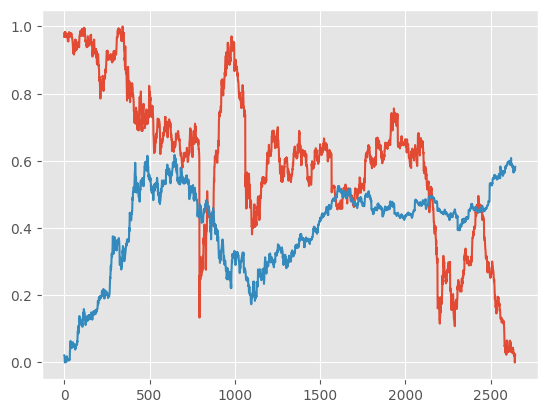

In [8]:
plt.plot(data)
plt.plot(data2)
plt.show()

In [9]:
data_tensor = torch.FloatTensor(np.vstack([data, data2]))
data0 = data_tensor[0]

In [10]:
data_tensor

tensor([[0.9690, 0.9797, 0.9823,  ..., 0.0000, 0.0196, 0.0226],
        [0.0209, 0.0197, 0.0155,  ..., 0.5743, 0.5740, 0.5823]])

In [11]:
def create_setA(data: np.array) -> torch.Tensor:
    set_A = torch.zeros(len(data), len(data))
    k = 1
    for i in range(len(data)):
        set_A[i, :k] = torch.FloatTensor(data[:k])
        k += 1
    
    return set_A

In [12]:
set_A = torch.stack(list(map(lambda x: create_setA(x), data)))

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
# set_A = create_setA(data)

## Data Preparation

In [822]:
n = 300
dt = 1/n

# data = dclProcess(n, 10).T
data = np.array([merton_process(s0=1, xiP=7, muj=0, sigmaj=0.3, r=0.04, sigma=0.6, n=n, T=1) for i in range(15)])
# data = np.array([geometric_BM(s0=1, mu=0.1, sigma=0.5, n=n, T=1) for i in range(10)])

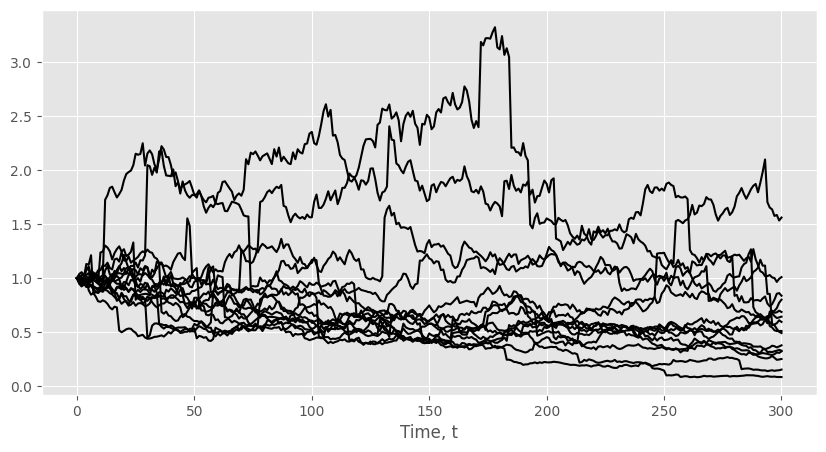

In [823]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data.T, color='black')

plt.xlabel('Time, t')
plt.show()

In [824]:
# data_array = []
# for i in data:
#     scaler = MinMaxScaler((0, 1))
#     data_array.append(scaler.fit_transform(i.reshape(-1, 1)).T)
    
# data_array = np.array(data_array)

In [825]:
scaler = MinMaxScaler((0, 1))
data = scaler.fit_transform(data.T).T

In [826]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

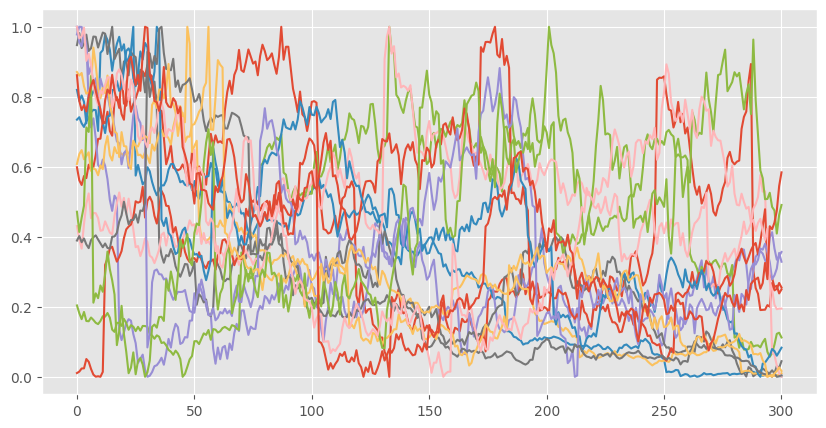

In [827]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data_tensor.T)
plt.show()

In [828]:
mu = 0.0
x0 = 0.0
theta = 15
sigma = 0.3
times = np.linspace(1/300, 1, 301)

In [25]:
cov_matrix = []
for i in range(n+1):
    row = []
    for j in range(n+1):
        row.append(sigma**2 / (2*theta) * (np.exp(-theta * np.abs(times[i]-times[j])) - np.exp(-theta * (times[i]+times[j]))))
        
    cov_matrix.append(row)
    
cov_matrix = torch.FloatTensor(cov_matrix)

In [26]:
mu_vector = torch.FloatTensor([mu + (x0 - mu) * torch.exp(torch.tensor(-theta * times[i])) for i in range(n+1)])

In [27]:
p_Z = MultivariateNormal(mu_vector, cov_matrix)
z = p_Z.rsample(sample_shape=(10,))

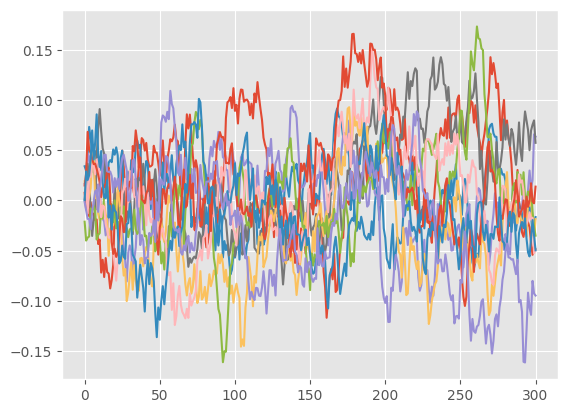

In [28]:
plt.plot(z.T)
plt.show()

In [29]:
p_Z.log_prob(z)

tensor([793.7314, 790.7509, 795.9006, 779.4921, 786.1642, 805.5997, 803.3480,
        795.1024, 787.5205, 811.8073])

In [30]:
ou_sample = torch.FloatTensor(ornstein_uhlenbeck_process(300, 10, mu=mu, theta=theta, sigma=sigma, x0=x0))

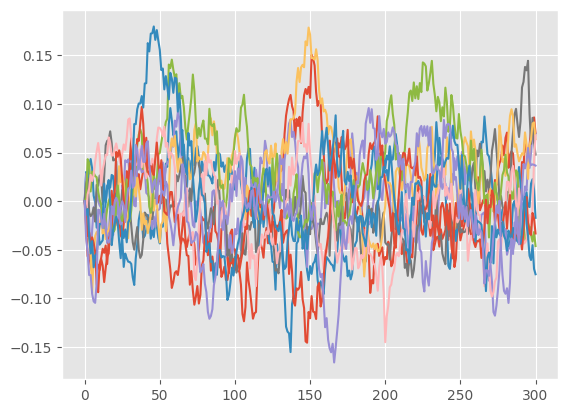

In [31]:
plt.plot(ou_sample.T)
plt.show()

In [32]:
p_Z.log_prob(ou_sample)

tensor([795.4177, 793.0671, 779.5563, 800.9431, 789.5756, 799.0344, 803.5778,
        808.8607, 782.4818, 791.8643])

## Identify jump intensity

In [835]:
idx_jumps = list(map(lambda x: find_jumps(x, 0.5), data_tensor))

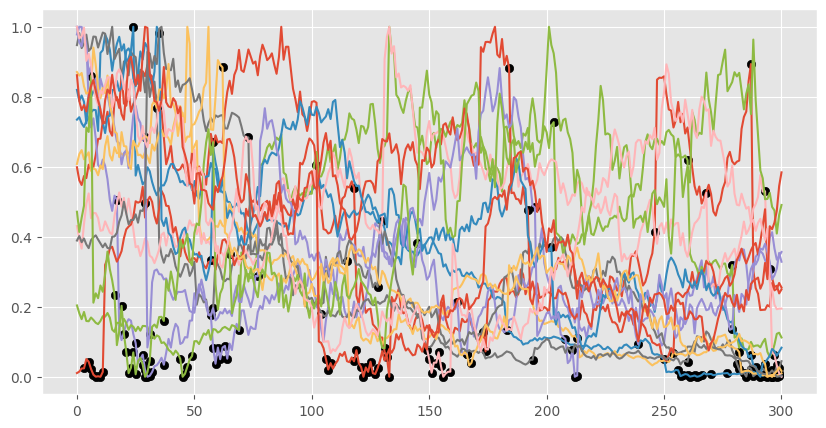

In [836]:
plot_jumps(data_tensor, idx_jumps)

In [837]:
calc_mean_jump(data_tensor, idx_jumps)

tensor(0.1512)

In [838]:
init_intensity = estimate_init_intensity_array(data_tensor, idx_jumps)/dt
init_intensity

array([ 6.97674419, 18.93687708, 16.94352159, 13.95348837,  7.97342193,
        8.97009967,  6.97674419, 10.96345515,  6.97674419,  9.96677741,
        8.97009967,  9.96677741, 17.94019934,  7.97342193, 13.95348837])

In [839]:
jump_part, diff_part = separate_dynamics(data_tensor, idx_jumps)
init_params = estimate_init_params(data_tensor, jump_part, diff_part, dt)
# likelihood_mjd(log_return(data_tensor[0]), init_params[0], init_intensity[0], dt)

In [840]:
opt_params = optimize_params(data_tensor, init_params, init_intensity, dt)

In [841]:
xiP0 = opt_params[-1]
xiP0

11.162790697674422

## Signature Examples

In [42]:
signature_traj = compute_path_signature_torch(data_tensor, level_threshold=3)
signature = signature_set(signature_traj)[1:]

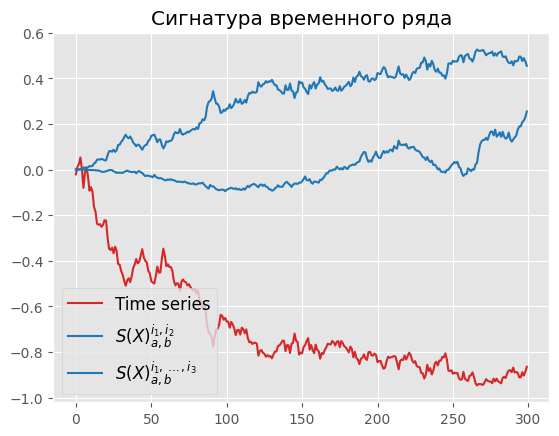

In [43]:
plt.plot(signature_traj[1][0], color='tab:red', label='Time series')
plt.plot(signature_traj[2][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
plt.plot(signature_traj[3][2], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_3}$')
# plt.plot(signature_traj[6][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_6}$')
# plt.plot(signature_traj[9][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_9}$')

plt.legend(fontsize=12, loc=3)
plt.title('Сигнатура временного ряда')
plt.show()

## Train model

In [944]:
class DiffMap(nn.Module):
    def __init__(self, time_steps, h_dim, latent_dim, dt, permute):

        super(DiffMap, self).__init__()
    
        # self.out_size = out_size
        
        self.h_dim = h_dim
        self.laten_dim = latent_dim
        self.time_steps = time_steps
        self.dt = dt
        # self.hidden_lp = 2**5
        hidden = 2**7
        self.v_dim = latent_dim
        self.d = h_dim // 2
        self.permute = permute
        
        # self.drift = Drift(self.v_dim)
        # self.diffusion = Diffusion(self.v_dim, 1)
        # self.jump = Jump(self.v_dim)
        # self.xiP = nn.Parameter(torch.rand(1))
        
        
        self.in_size = self.d
        self.out_size = self.h_dim - self.d
    
        if self.permute:
            self.in_size, self.out_size = self.out_size, self.in_size
        
        
        self.fc_mu = nn.Sequential(
            nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            extract_tensor(),
            nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.fc_sig = nn.Sequential(
            nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            extract_tensor(),
            nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.fc_nu = nn.Sequential(
            nn.LSTM(self.out_size, self.out_size, num_layers=1, batch_first=True),
            extract_tensor(),
            nn.Sigmoid(),
            nn.Linear(self.out_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.in_size)
        )
        
        # self.xi = Operator_F(self.time_steps, self.out_size)
        # self.psi = Operator_F(self.h_dim, self.h_dim)
        # self.time_grid = torch.FloatTensor(np.cumsum(np.zeros(self.v_dim) + 1/self.v_dim))
        
        # self.h_dim_v = 1
        # self.z_dim = 30
        # self.phi = Phi(self.z_dim, 1, 1)
        # self.mu_v = Mu_V(1, self.h_dim_v, h_dim)
        # self.sigma_v = Sigma_V(1, self.h_dim_v, h_dim)

        
        self.base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))
        # self.base_dist = MultivariateNormal(mu_vector, cov_matrix)

    def forward(self, x):
        
        x1, x2 = x[:, :self.d], x[:, self.d:]
        
        if self.permute:
            x2, x1 = x1, x2
        
        z1 = x1 + self.fc_nu(x2)
        sig = self.fc_sig(z1)
        
    
        z2 = self.fc_mu(z1) + x2 * torch.exp(sig)
        
        if self.permute:
            z2, z1 = z1, z2
 
        z = torch.cat([z1, z2], axis=1)

        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)
        
        return z, log_pz, log_jacob

    def inverse(self, z):
    
        z1, z2 = z[:, :self.d], z[:, self.d:]
        
        if self.permute:
            z2, z1 = z1, z2
            
        
        x2 = (z2 - self.fc_mu(z1)) * torch.exp(-self.fc_sig(z1))
        x1 = z1 - self.fc_nu(x2)
      
        
        if self.permute:
            x2, x1 = x1, x2
        
        x = torch.cat([x1, x2], axis=1)

        return x




class Flow(nn.Module):
    def __init__(self, n_flows, h_dim, M, time_steps, dt, sig_dim, xiP0):
        super(Flow, self).__init__()
        
        self.h_dim = h_dim
        self.permute = [True if i % 2 else False for i in range(n_flows)]

        self.bijections = nn.ModuleList(
            [DiffMap(time_steps, h_dim, M, dt, self.permute[i]) for i in range(n_flows)]
        )
        
        
        # self.xiP = nn.Parameter(torch.tensor(xiP0), requires_grad=True)
        # self.fc_xi = nn.Sequential(nn.Linear(10, 2**6), nn.ReLU(), nn.Linear(2**6, 1))
        # self.xiP0 = xiP0
        self.xiP = xiP0
        
        self.time_steps = time_steps
        self.dt = dt
        self.v_dim = M
        self.psi = Operator_F(self.time_steps, self.h_dim)
        self.zeta = Operator_F(self.h_dim, self.h_dim)
        
        self.drift = Drift(self.v_dim)
        self.diffusion = Diffusion(self.v_dim, 1)
        self.jump = Jump(self.v_dim)
        self.phi = Phi(self.v_dim, M, M)
        self.sigmoid_sig = nn.Sigmoid()
        
        
        self.fc_signature = nn.Sequential(nn.Linear(sig_dim, 2**7), nn.Sigmoid())

    def forward(self, x):
        log_jacobs = []
        
        wt = torch.randn((1, self.v_dim))
        v0 = self.phi(wt, x[:, 0].view(1, x.size(0)))
        # self.xiP = torch.abs(self.fc_xi(x[:, 0].view(1, -1)).squeeze(0).squeeze(0))
        vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)
        
        self.non_linearity = torch.exp(-self.psi(vt.T))
        x = self.non_linearity * x + self.zeta(self.non_linearity)

        for bijection in self.bijections:
            
            # wt = torch.randn((1, self.v_dim))
            # v0 = self.phi(wt, x[:, 0].view(1, x.size(0)))
            # # self.xiP = torch.abs(self.fc_xi(x[:, 0].view(1, -1)).squeeze(0).squeeze(0))
            # vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)
            
            # self.non_linearity = torch.exp(-self.psi(vt.T))
            # x = self.non_linearity * x + self.zeta(self.non_linearity)

            x, log_pz, lj = bijection(x)

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs), v0

    def inverse(self, z):

        for bijection in reversed(self.bijections):
            z = bijection.inverse(z)
            
        
        wt = torch.randn((1, self.v_dim))
        v0 = self.phi(wt, z[:, 0].view(1, z.size(0)))
        # self.xiP = torch.abs(self.fc_xi(z[:, 0].view(1, -1)).squeeze(0).squeeze(0))
        vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)
        
        self.non_linearity = torch.exp(-self.psi(vt.T))
        z = (z - self.zeta(self.non_linearity)) / self.non_linearity


        return z
    
    def fit(self, X, epochs=800, learning_rate=1e-3):
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[500, 900], gamma=0.3)
        self.x_mean = torch.mean(X, dim=0)
        self.x_std = torch.std(X, dim=0)

        losses = []
        # softmax = nn.Softmax()
        mse = nn.MSELoss()
        # kl = nn.KLDivLoss()
        epochs = tqdm(range(epochs))

        for _ in epochs:
            _, log_pz, log_jacob, v0 = self.forward(X)
            
            # z = torch.FloatTensor(ornstein_uhlenbeck_process(self.h_dim - 1, self.v_dim, mu=0.0, theta=5, sigma=0.3, x0=0.0))
            
            p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
            # p_Z = MultivariateNormal(mu_vector, cov_matrix)
            z = p_Z.rsample(sample_shape=(X.size(0),))
            synth_x = self.inverse(z)
    
            signature = (stack_signatures(compute_path_signature_torch(synth_x, level_threshold=2)[1:]))
            signature_true = (stack_signatures(compute_path_signature_torch(X, level_threshold=2)[1:]))
            
            loss_likelihood = (-log_pz - log_jacob).mean()
            loss_sig = mse(signature, signature_true)
            loss_init_values = torch.mean((X[:, 0] - synth_x[:, 0])**2)
            # loss_intensity = (self.xiP - self.xiP0)**2
        
        
            loss = loss_likelihood + loss_init_values + 0.01 * loss_sig
            

            optim.zero_grad()
            loss.backward()
            optim.step()
            scheduler.step()

            epochs.set_description(f'Loss: {round(loss.item(), 4)}')
            losses.append([loss_likelihood.item(), loss_init_values.item(), loss_sig.item()])
            
        return np.array(losses)
            
    
    def sample(self, n_samples):
        samples_array = []
            
        if n_samples % self.v_dim == 0:
            for i in range(n_samples // self.v_dim):
                p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
                # p_Z = MultivariateNormal(mu_vector, cov_matrix)
                z = p_Z.rsample(sample_shape=(self.v_dim,))

                X_sample = self.inverse(z).detach().numpy()
                samples_array.append(X_sample)
                
            samples_array = np.vstack(samples_array)
                
        else:
            for i in range(n_samples // self.v_dim + 1):
                p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
                # p_Z = MultivariateNormal(mu_vector, cov_matrix)
                z = p_Z.rsample(sample_shape=(self.v_dim,))

                X_sample = self.inverse(z).detach().numpy()
                samples_array.append(X_sample)
              
            samples_array = np.vstack(samples_array)[:n_samples]

        return samples_array

In [945]:
# data_tensor = data_tensor.view(1, -1)

In [946]:
data_tensor.size()

torch.Size([15, 301])

In [955]:
h_dim = len(data_tensor[0])
M = data_tensor.size(0)
time_steps = 20
dt = torch.FloatTensor([1/time_steps])
# n = data_tensor.size(0)
sig_dim = n + n**2 
# + n**3

In [956]:
# nsde_flow = Flow(128, 10, h_dim, h_dim)
n_flows = 8

nsde_flow = Flow(n_flows, h_dim, M, time_steps, dt, sig_dim, xiP0)

losses = nsde_flow.fit(data_tensor, epochs=1000)

Loss: -1047.5326: 100%|██████████| 1000/1000 [03:56<00:00,  4.23it/s]


In [957]:
nsde_flow.eval()

Flow(
  (bijections): ModuleList(
    (0): DiffMap(
      (fc_mu): Sequential(
        (0): LSTM(150, 150, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=150, out_features=128, bias=True)
        (4): Sigmoid()
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Sigmoid()
        (7): Linear(in_features=128, out_features=151, bias=True)
      )
      (fc_sig): Sequential(
        (0): LSTM(150, 150, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=150, out_features=128, bias=True)
        (4): Sigmoid()
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Sigmoid()
        (7): Linear(in_features=128, out_features=151, bias=True)
      )
      (fc_nu): Sequential(
        (0): LSTM(151, 151, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=151, out_features=128, bias=True)

In [958]:
# u = nsde_flow.forward(data_tensor)[0].detach()

In [959]:
samples = nsde_flow.sample(17)
# samples = samples[(~(np.max(samples, axis=1) > 1.5*np.max(data))) & (~(np.min(samples, axis=1) < 1.5*np.min(data)))]

In [960]:
samples.shape

(17, 301)

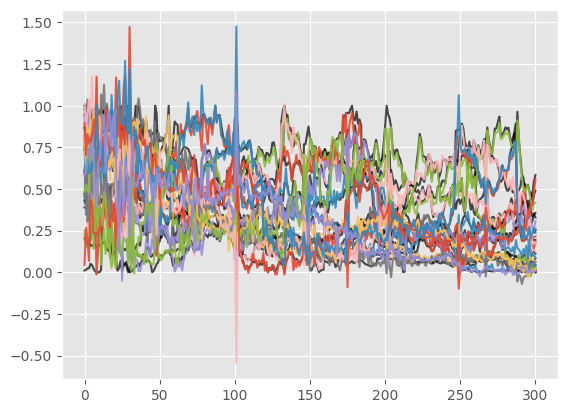

In [961]:
plt.plot(data_tensor.T, color='black', alpha=0.7, label='Real')
plt.plot(samples[:, :].T, alpha=0.9, label='Synth')

# plt.legend()
plt.show()

In [962]:
# fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

# plt.plot(data_tensor.T, color='black', alpha=0.6, label='Real')
# plt.plot(samples.T, alpha=0.9, label='Synth')

# handles, labels = ax.get_legend_handles_labels()
# fig.legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc='upper center')

# # plt.legend()
# plt.ylabel('Values')
# plt.xlabel('Time')

# plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth.pdf', dpi=300)
# plt.show()

In [963]:
def inverse_preprocessing(samples):
    synth_data = []

    if samples.shape[0] % M == 0:
        for i in range(samples.shape[0] // M):
            synth_data.append(scaler.inverse_transform(samples[M*i:M*(i+1)].T).T)
            
    else:
        for i in range(samples.shape[0] // M):
            synth_data.append(scaler.inverse_transform(samples[M*i:M*(i+1)].T).T)
            
        last = samples.shape[0] % M
        synth_data.append(scaler.inverse_transform(np.vstack([samples[-last:], np.ones((M - last, samples.shape[1]))]).T).T[:last])
        
    synth_data = np.vstack(synth_data)
    
    return synth_data

In [964]:
synth_data = inverse_preprocessing(samples)
real_data = scaler.inverse_transform(data.T).T

In [965]:
# synth_data = []

# if samples.shape[0] % M == 0:
#     for i in range(samples.shape[0] // M):
#         synth_data.append(scaler.inverse_transform(samples[M*i:M*(i+1)].T).T)
        
# else:
#     for i in range(samples.shape[0] // M):
#         synth_data.append(scaler.inverse_transform(samples[M*i:M*(i+1)].T).T)
        
#     last = samples.shape[0] % M
#     synth_data.append(scaler.inverse_transform(np.vstack([samples[-last:], np.ones((M - last, samples.shape[1]))]).T).T[:last])
    
# synth_data = np.vstack(synth_data)

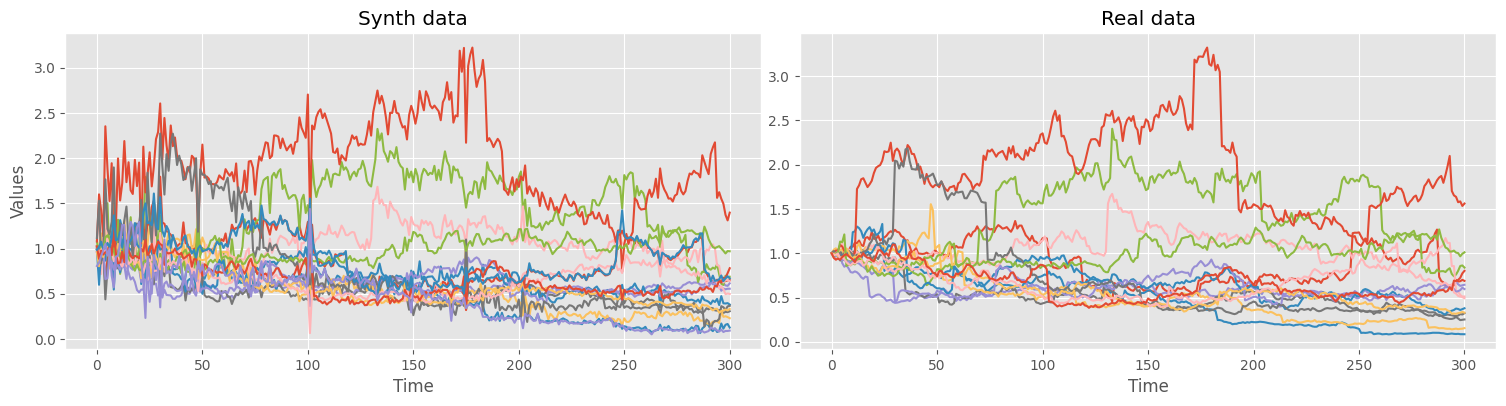

In [966]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_data.T)
axs[0].set_title('Synth data')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(real_data.T)
axs[1].set_title('Real data')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth.pdf', dpi=300)
plt.show()

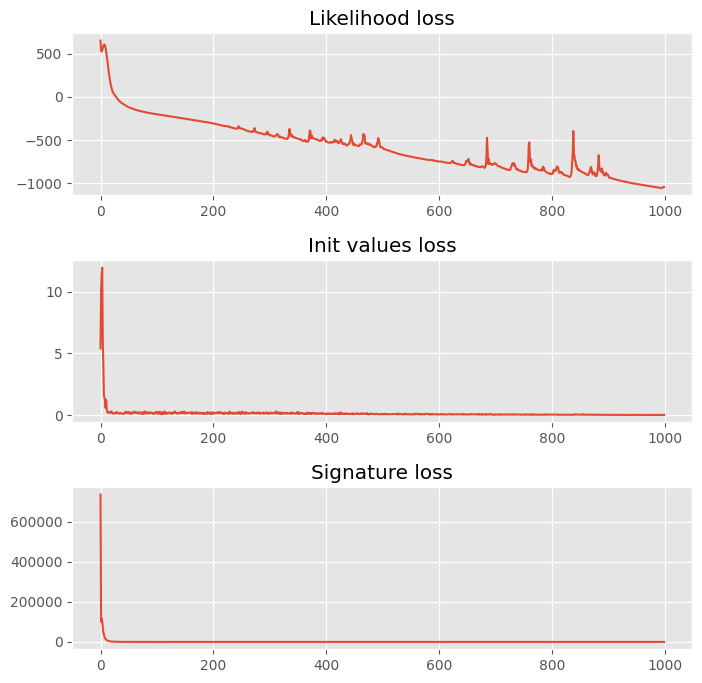

In [967]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(losses.T[0])
axs[0].set_title('Likelihood loss')

axs[1].plot(losses.T[1])
axs[1].set_title('Init values loss')

axs[2].plot(losses.T[2])
axs[2].set_title('Signature loss')

plt.subplots_adjust(hspace=0.4)
plt.show()

In [281]:
from __future__ import absolute_import, division, print_function


def flip(x, dim):

    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[
        :, getattr(torch.arange(x.size(1) - 1, -1, -1), ("cpu", "cuda")[x.is_cuda])().long(), :
    ]
    return x.view(xsize)


def reconstruct_DFT(x, component="real"):

    if component == "real":
        x_rec = torch.cat([x[0, :], flip(x[0, :], dim=0)[1:]], dim=0)

    elif component == "imag":
        x_rec = torch.cat([x[1, :], -1 * flip(x[1, :], dim=0)[1:]], dim=0)

    return x_rec


class DFT(nn.Module):

    def __init__(self, N_fft=100):

        super(DFT, self).__init__()

        self.N_fft = N_fft
        self.crop_size = int(self.N_fft / 2) + 1
        base_mu, base_cov = torch.zeros(self.crop_size * 2), torch.eye(self.crop_size * 2)
        self.base_dist = MultivariateNormal(base_mu, base_cov)

    def forward(self, x):

        if len(x.shape) == 1:

            x = x.reshape((1, -1))

        x_numpy = x.detach().float()
        X_fft = [np.fft.fftshift(np.fft.fft(x_numpy[k, :])) for k in range(x.shape[0])]
        X_fft_train = np.array(
            [
                np.array(
                    [np.real(X_fft[k])[: self.crop_size] / self.N_fft, np.imag(X_fft[k])[: self.crop_size] / self.N_fft]
                )
                for k in range(len(X_fft))
            ]
        )
        x_fft = torch.from_numpy(X_fft_train).float()

        log_pz = self.base_dist.log_prob(x_fft.view(-1, x_fft.shape[1] * x_fft.shape[2]))
        log_jacob = 0

        return x_fft, log_pz, log_jacob

    def inverse(self, x):


        x_numpy = x.view((-1, 2, self.crop_size))

        x_numpy_r = [
            reconstruct_DFT(x_numpy[u, :, :], component="real").detach().numpy() for u in range(x_numpy.shape[0])
        ]
        x_numpy_i = [
            reconstruct_DFT(x_numpy[u, :, :], component="imag").detach().numpy() for u in range(x_numpy.shape[0])
        ]

        x_ifft = [
            self.N_fft * np.real(np.fft.ifft(np.fft.ifftshift(x_numpy_r[u] + 1j * x_numpy_i[u])))
            for u in range(x_numpy.shape[0])
        ]
        x_ifft_out = torch.from_numpy(np.array(x_ifft)).float()

        return x_ifft_out



class SpectralFilter(nn.Module):
    def __init__(self, d, k, FFT, hidden, flip=False, RNN=False):

        super().__init__()

        self.d, self.k = d, k

        if FFT:

            self.out_size = self.d - self.k + 1
            self.pz_size = self.d + 1
            self.in_size = self.k

        else:

            self.out_size = self.d - self.k
            self.pz_size = self.d
            self.in_size = self.k

        if flip:

            self.in_size, self.out_size = self.out_size, self.in_size

        self.sig_net = nn.Sequential(  # RNN(mode="RNN", HIDDEN_UNITS=20, INPUT_SIZE=1,),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),  # nn.LeakyReLU(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),  # nn.Tanh(),
            nn.Linear(hidden, self.out_size),
        )

        self.mu_net = nn.Sequential(  # RNN(mode="RNN", HIDDEN_UNITS=20, INPUT_SIZE=1,),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),  # nn.LeakyReLU(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),  # nn.Tanh(),
            nn.Linear(hidden, self.out_size),
        )

        base_mu, base_cov = torch.zeros(self.pz_size), torch.eye(self.pz_size)
        self.base_dist = MultivariateNormal(base_mu, base_cov)

    def forward(self, x, flip=False):
        x1, x2 = x[:, : self.k], x[:, self.k :]

        if flip:

            x2, x1 = x1, x2

        # forward

        sig = self.sig_net(x1).view(-1, self.out_size)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1).view(-1, self.out_size)

        if flip:

            z2, z1 = z1, z2

        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = self.base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
    

        return z_hat, log_pz, log_jacob

    def inverse(self, Z, flip=False):

        z1, z2 = Z[:, : self.k], Z[:, self.k :]

        if flip:
            z2, z1 = z1, z2

        x1 = z1

        sig_in = self.sig_net(z1).view(-1, self.out_size)
        x2 = (z2 - self.mu_net(z1).view(-1, self.out_size)) * torch.exp(-sig_in)

        if flip:

            x2, x1 = x1, x2

        return torch.cat([x1, x2], -1)


class FourierFlow(nn.Module):
    def __init__(self, hidden, fft_size, n_flows, FFT=True, flip=True, normalize=False):

        super().__init__()

        self.d = fft_size
        self.k = int(fft_size / 2) + 1
        self.fft_size = fft_size
        self.FFT = FFT
        self.normalize = normalize

        if flip:

            self.flips = [True if i % 2 else False for i in range(n_flows)]

        else:

            self.flips = [False for i in range(n_flows)]

        self.bijectors = nn.ModuleList(
            [SpectralFilter(self.d, self.k, self.FFT, hidden=hidden, flip=self.flips[_]) for _ in range(n_flows)]
        )

        self.FourierTransform = DFT(N_fft=self.fft_size)

    def forward(self, x):

        if self.FFT:

            x = self.FourierTransform(x)[0] + 1e-5

            if self.normalize:
                x = (x - self.fft_mean) / self.fft_std
      
            x = x.view(-1, self.d + 1)
          

        log_jacobs = []

        for bijector, f in zip(self.bijectors, self.flips):

            x, log_pz, lj = bijector(x, flip=f)

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):

        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):

            z = bijector.inverse(z, flip=f)

        if self.FFT:

            if self.normalize:
                z = z * self.fft_std.view(-1, self.d + 1) + self.fft_mean.view(-1, self.d + 1)

            z = self.FourierTransform.inverse(z)

        return z.detach().numpy()

    def fit(self, X, epochs=500, learning_rate=1e-3, display_step=100):

        X_train = torch.from_numpy(np.array(X)).float()

        # for normalizing the spectral transforms
        X_train_spectral = self.FourierTransform(X_train)[0]
        self.fft_mean = torch.mean(X_train_spectral, dim=0)
        self.fft_std = torch.std(X_train_spectral, dim=0)

        self.d = X_train.shape[1]
        self.k = int(np.floor(X_train.shape[1] / 2))

        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

        epochs = tqdm(range(epochs))

        for _ in epochs:

            optim.zero_grad()

            _, log_pz, log_jacob = self(X_train)
            loss = (-log_pz - log_jacob).mean()

            loss.backward()
            optim.step()
            scheduler.step()

            epochs.set_description(f'Loss: {loss.item()}')

    def sample(self, n_samples):

        if self.FFT:

            mu, cov = torch.zeros(self.d + 1), torch.eye(self.d + 1)

        else:

            mu, cov = torch.zeros(self.d), torch.eye(self.d)

        p_Z = MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))

        X_sample = self.inverse(z)

        return X_sample

In [294]:
data_tensor = data_tensor[:, :(len(data_tensor[0]) // 4 * 4 + 1 if len(data_tensor[0]) % 4 > 0 else len(data_tensor[0]) - 3)]

In [295]:
fourier_flow = FourierFlow(2**8, len(data_tensor[0]), 10, FFT=True, flip=True, normalize=False)

fourier_flow.fit(data_tensor, epochs=1000)

Loss: -2707.49755859375: 100%|██████████| 1000/1000 [00:23<00:00, 43.01it/s] 


In [296]:
rnvp_flow = FourierFlow(2**8, len(data_tensor[0]), 10, FFT=False, flip=True, normalize=False)

rnvp_flow.fit(data_tensor, epochs=1000)

Loss: -1088.3861083984375: 100%|██████████| 1000/1000 [00:23<00:00, 41.98it/s]


In [297]:
samples_ff = fourier_flow.sample(10)
samples_rnvp = fourier_flow.sample(10)

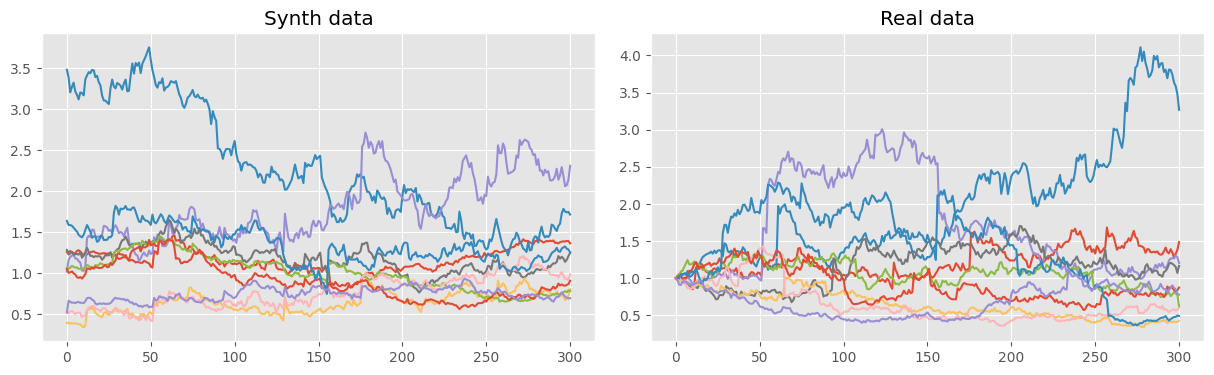

In [299]:
synth_ff = scaler.inverse_transform(samples_ff.T).T
synth_rnvp = scaler.inverse_transform(samples_rnvp.T).T
real_data = scaler.inverse_transform(data.T).T

fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_ff.T)
axs[0].set_title('Synth data')

axs[1].plot(real_data.T)
axs[1].set_title('Real data')
# axs[1].legend()

plt.subplots_adjust(wspace=0.1)
plt.show()

## Evaluate

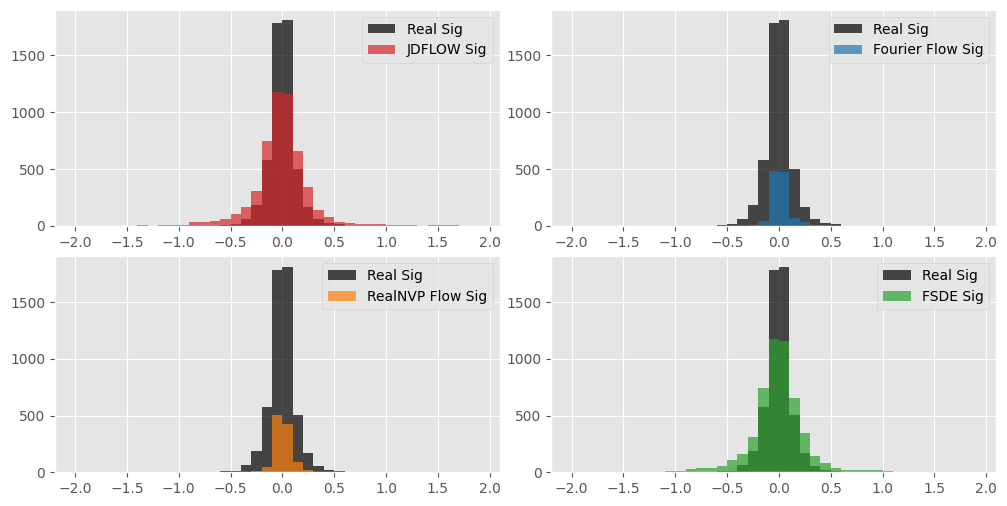

In [813]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples), level_threshold=3)
signature = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(data_tensor, level_threshold=3)
signature_real = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_ff), level_threshold=3)
signature_ff = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_rnvp), level_threshold=3)
signature_rnvp = signature_set(signature_traj)[1:]



axs[0, 0].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.7)
axs[0, 0].hist(signature, bins=np.arange(-2, 2, 0.1), label='JDFLOW Sig', color='tab:red', alpha=0.7)
axs[0, 0].legend()


axs[0, 1].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.7)
axs[0, 1].hist(signature_ff, bins=np.arange(-2, 2, 0.1), label='Fourier Flow Sig', color='tab:blue', alpha=0.7)
axs[0, 1].legend()


axs[1, 0].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.7)
axs[1, 0].hist(signature_rnvp, bins=np.arange(-2, 2, 0.1), label='RealNVP Flow Sig', color='tab:orange', alpha=0.7)
axs[1, 0].legend()


axs[1, 1].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.7)
axs[1, 1].hist(signature, bins=np.arange(-2, 2, 0.1), label='FSDE Sig', color='tab:green', alpha=0.7)
axs[1, 1].legend()


plt.tight_layout(pad=0.5)
plt.show()

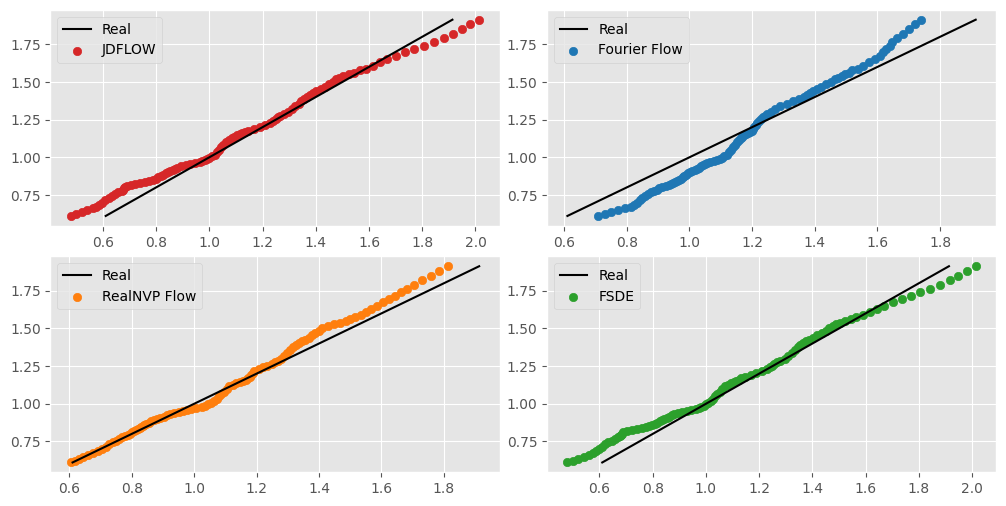

In [340]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

# plt.plot(np.arange(2), label='Real', color='black')

axs[0, 0].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[0, 0].scatter(extr_quant_computation(synth_data), extr_quant_computation(real_data), color='tab:red', label='JDFLOW')
axs[0, 0].legend()


axs[0, 1].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[0, 1].scatter(extr_quant_computation(synth_ff), extr_quant_computation(real_data), color='tab:blue', label='Fourier Flow')
axs[0, 1].legend()


axs[1, 0].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[1, 0].scatter(extr_quant_computation(synth_rnvp), extr_quant_computation(real_data), color='tab:orange', label='RealNVP Flow')
axs[1, 0].legend()


axs[1, 1].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[1, 1].scatter(extr_quant_computation(synth_data), extr_quant_computation(real_data), color='tab:green', label='FSDE')
axs[1, 1].legend()


plt.tight_layout(pad=0.5)
plt.show()

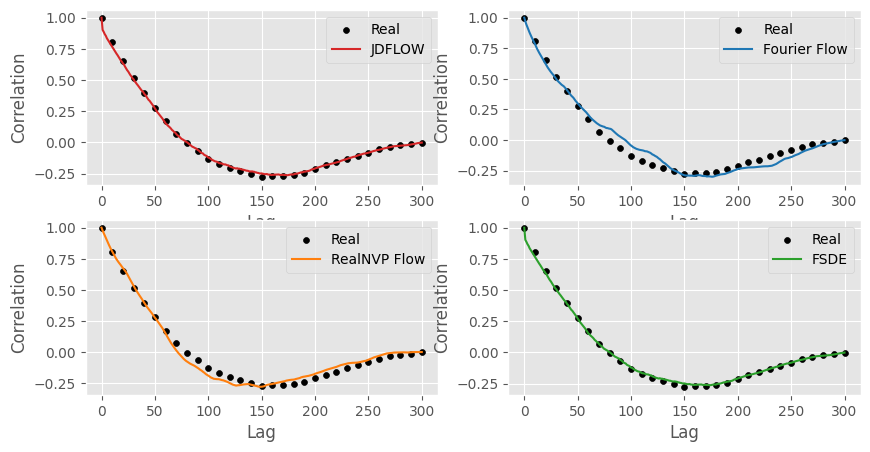

In [339]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[0, 0].plot(autocorr_vec(synth_data), label = 'JDFLOW', color='tab:red')
axs[0, 0].set_xlabel('Lag')
axs[0, 0].set_ylabel('Correlation')
axs[0, 0].legend()


axs[0, 1].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[0, 1].plot(autocorr_vec(synth_ff), label = 'Fourier Flow', color='tab:blue')
axs[0, 1].set_xlabel('Lag')
axs[0, 1].set_ylabel('Correlation')
axs[0, 1].legend()

axs[1, 0].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[1, 0].plot(autocorr_vec(synth_rnvp), label = 'RealNVP Flow', color='tab:orange')
axs[1, 0].set_xlabel('Lag')
axs[1, 0].set_ylabel('Correlation')
axs[1, 0].legend()

axs[1, 1].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[1, 1].plot(autocorr_vec(synth_data), label = 'FSDE', color='tab:green')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('Correlation')
axs[1, 1].legend()


plt.xticks()
plt.yticks()
# plt.savefig(f'Autocorr_{name}.pdf', dpi=300) #save figure
plt.show()

In [346]:
from FractionalSDE.utils.neural_net import LatentFSDEfunc, LatentODEfunc, GeneratorRNN
from FractionalSDE.utils.neural_net import LatentSDEfunc, latent_dim, batch_dim, nhidden_rnn
from FractionalSDE.utils.utils import RunningAverageMeter, log_normal_pdf, normal_kl, calculate_log_likelihood
from FractionalSDE.utils.plots import plot_generated_paths, plot_original_path, plot_hist
from FractionalSDE.utils.utils import save_csv, tensor_to_numpy
import argparse
from torchdiffeq import odeint
from torchsde import sdeint
from FractionalSDE.utils.fsde_solver import fsdeint

In [372]:
def train(data, method, epochs):
    batch_dim = 3
    device='cpu'
    train_data = data.to(device) 
    train_ts = torch.tensor(np.arange(len(train_data)))
 
    
    if method == "RNN":
        rnn = GeneratorRNN().to(device)
        params = list(rnn.parameters()) 
    elif method == "SDE":
        func_SDE = LatentSDEfunc().to(device)
        params = list(func_SDE.parameters()) 
    elif method == "fSDE":
        func_fSDE = LatentFSDEfunc().to(device)
        params = (list(func_fSDE.parameters())) 

    optimizer = optim.Adam(params, lr=1e-2)
    
    for itr in range(1, epochs + 1):
        optimizer.zero_grad()
  
        z0 = torch.zeros(batch_dim, latent_dim) + train_data[0, 0]
        
        
        if method == "RNN":
            h = torch.randn(train_data.size(0), batch_dim, nhidden_rnn)
            z = z0
            pred_return = torch.zeros(batch_dim, latent_dim)
            for k in range(train_data.size(0)-1):        
                z, h_out = rnn(z, h[k])
                pred_return = torch.cat((pred_return, h_out), dim=1)
            pred_return = torch.cumsum(pred_return.unsqueeze(-1), dim=1)
            pred_z = torch.zeros(batch_dim, train_data.size(0), latent_dim) + train_data[0, 0] - pred_return
        elif method == "SDE":
            # dimension of sdeint is (t_size, batch_size, latent_size)
            pred_z = sdeint(func_SDE, z0, train_ts).permute(1, 0, 2)
        elif method == "fSDE":
            # dimension of fsdeint is (batch_size, t_size, latent_size)
            pred_z = fsdeint(func_fSDE, 0.7, z0, train_ts) #.permute(0, 2, 1)
    

        with torch.autograd.set_detect_anomaly(True):
            loss = - calculate_log_likelihood(pred_z[:,:,0], train_data[:,0])
        
            reg_lambda = 0
            reg = torch.tensor(0.) 
            for param in params:
                reg += torch.norm(param, 1)
            loss += reg_lambda * reg

            loss.backward()
            optimizer.step()
        
        # if itr%100==0:
        print("Iter: {}, Log Likelihood: {:.4f}, Regularization: {:.4f}".format(itr, -loss, reg))        
    # print(f'Training complete after {itr} iters.\n')
    
    
    # Generation of sample paths
    with torch.no_grad():
        x0 = torch.zeros(batch_dim, latent_dim) + train_data[0, 0]

        
        if method == 'RNN':
            h = torch.randn(train_data.size(0), batch_dim, nhidden_rnn)
            x = x0
            return_pred = torch.zeros(batch_dim, latent_dim)
            for k in range(train_data.size(0)-1):        
                x, h_out = rnn(x, h[k])
                return_pred = torch.cat((return_pred, h_out), dim=1)
            return_pred = torch.cumsum(return_pred.unsqueeze(-1), dim=1)
            xs_gen = torch.zeros(batch_dim, train_data.size(0), latent_dim) + train_data[0, 0] - return_pred
        elif method == 'SDE':
            xs_gen = sdeint(func_SDE, x0, torch.tensor(np.arange(len(train_data)))).permute(1, 0, 2)
        elif method == 'fSDE':
            xs_gen = fsdeint(func_fSDE, 0.7, x0, torch.tensor(np.arange(len(train_data))))
        
        # plot_original_path(data_name, ts_total, data_total)
        # plot_generated_paths(min([args.num_paths, batch_dim]), data_name, method, ts_total, data_total, xs_gen)
        xs_gen_np = tensor_to_numpy(xs_gen[:,:,0]) 
        # save_csv(data_name, method, ts_total_str, data_total.reshape(-1), xs_gen_np)
        # plot_hist(data_name, method, xs_gen_np[0], train_data)
    return xs_gen_np


samples_fsde = train(data_tensor[0].view(-1, 1), method='fSDE', epochs=10)

Iter: 1, Log Likelihood: -1.5414, Regularization: 186.4522
Iter: 2, Log Likelihood: -2.0609, Regularization: 186.3600
Iter: 3, Log Likelihood: -1.4951, Regularization: 186.4844
Iter: 4, Log Likelihood: -1.1761, Regularization: 186.6216
Iter: 5, Log Likelihood: -2.2370, Regularization: 186.7815
Iter: 6, Log Likelihood: -1.9302, Regularization: 186.9934
Iter: 7, Log Likelihood: -4.2462, Regularization: 187.2173
Iter: 8, Log Likelihood: -2.2245, Regularization: 187.3210
Iter: 9, Log Likelihood: -2.2380, Regularization: 187.4869
Iter: 10, Log Likelihood: -2.5215, Regularization: 187.7103


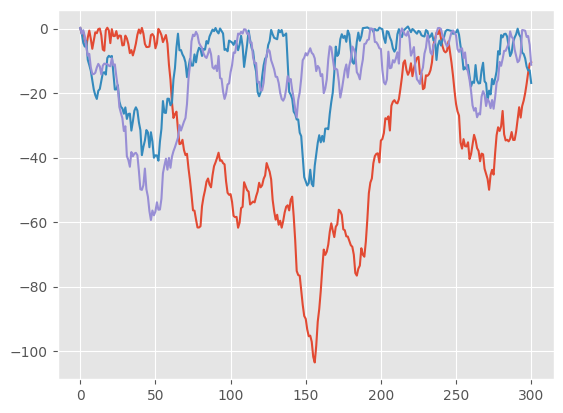

In [373]:
plt.plot(samples_fsde.T)
plt.show()

In [179]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

n = 31
test_size = 60
train_size_init = int(len(data) - n*test_size)

def forecasting_cv(synth, real, train_size_init, test_size, n):
    array_mse = []
    train = synth[:train_size_init]
    train_size = train_size_init

    for i in range(n):
        df = pd.DataFrame()
        df['y'] = train
        df.index = pd.date_range(start='1/1/2022', periods=len(train), freq='D')
        df = df.reset_index()
        df = df.rename(columns={'index': 'ds'})

        m = Prophet(daily_seasonality=True)
        m.fit(df)
        
        future = m.make_future_dataframe(periods = test_size)
        pred_synth = m.predict(future)['yhat'][-test_size:]
        
        test_synth = synth[train_size : (train_size+test_size)]
        test_real = real[train_size : (train_size+test_size)]
        
        mse = mean_squared_error(pred_synth.values, test_real)
        
        train = np.concatenate([train, test_synth])
        
        train_size += test_size
        
        array_mse.append(mse)
        
    return array_mse

ModuleNotFoundError: No module named 'fbprophet'

In [524]:
drift = Drift(h_dim)
diffusion = Diffusion(h_dim, 1)
jump = Jump(h_dim)

optim_drift = optim.Adam(drift.parameters(), lr=1e-3)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=1e-3)
optim_jump = optim.Adam(jump.parameters(), lr=1e-3)
scheduler_drift = optim.lr_scheduler.MultiStepLR(optim_drift, milestones=[20], gamma=0.3)
scheduler_diffusion = optim.lr_scheduler.MultiStepLR(optim_diffusion, milestones=[20], gamma=0.3)
scheduler_jump = optim.lr_scheduler.MultiStepLR(optim_jump, milestones=[20], gamma=0.3)

epochs_j = tqdm(range(40))
loss_array_j = []
mse_j = nn.MSELoss()

base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))
z = u[0].view(1, -1)
xiP = 30

for _ in epochs_j:  
    # z = base_dist.rsample((10, ))
    
    # xiP = xi()
    
    x = sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, xiP)
    # inv_sol = sdeint_jump_inverse(drift, diffusion, jump, dt, x.detach(), time_steps, h_dim).detach()
    sol = x
    
    loss_v = mse_j(sol, u) + torch.mean((sol[0] - u[0])**2)
    
    # for dp in drift.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    # for dp in diffusion.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    # for dp in jump.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    
    optim_drift.zero_grad()
    optim_diffusion.zero_grad()
    optim_jump.zero_grad()
    optim_xi.zero_grad()
    
    loss_v.backward()
    
    optim_drift.step()
    optim_diffusion.step()
    optim_jump.step()
    optim_xi.step()
    
    scheduler_drift.step()
    scheduler_diffusion.step()
    scheduler_jump.step()
    
    epochs_j.set_description(f'Loss: {loss_v.item()}')
    loss_array_j.append(loss_v.item())


Loss: 0.11530408263206482: 100%|██████████| 40/40 [04:04<00:00,  6.10s/it]


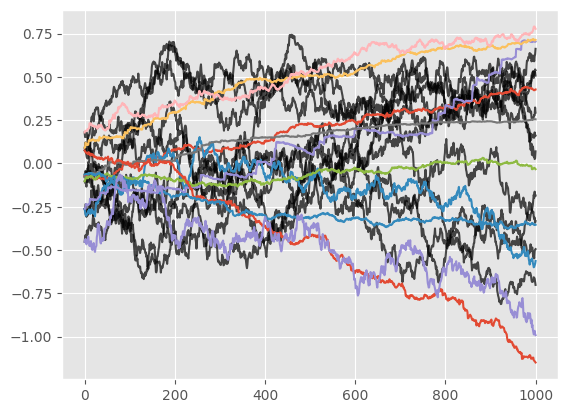

In [529]:
sol = sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, 30)

plt.plot(u, alpha=0.7, color='black')
plt.plot(sol.detach().numpy())

plt.show()

## NSDE for each record

In [66]:
u = data_tensor.T
h_dim = len(u[0])
time_steps = h_dim
dt = torch.FloatTensor([1/time_steps])

drift = Drift(1)
diffusion = Diffusion(1, 1)
jump = Jump(1)
f = Operator_F(h_dim, h_dim)

optim_drift = optim.Adam(drift.parameters(), lr=3e-4)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=3e-4)
optim_jump = optim.Adam(jump.parameters(), lr=3e-4)
optim_f = optim.Adam(f.parameters(), lr=3e-4)

In [67]:
# h_dim

10

In [430]:
epochs_j = tqdm(range(10))
loss_array_j = []
mse_j = nn.MSELoss()

for _ in epochs_j:  
    sol = torch.stack(sdeint_jump_1d(drift, diffusion, jump, dt, u[:, 0].view(-1, 1), time_steps)).squeeze(-1).T
    
    loss_v = mse_j(f(sol), u)

    
    optim_drift.zero_grad()
    optim_diffusion.zero_grad()
    optim_jump.zero_grad()
    optim_f.zero_grad()
    
    loss_v.backward()
    
    optim_drift.step()
    optim_diffusion.step()
    optim_jump.step()
    optim_f.step()
    
    epochs_j.set_description(f'Loss: {loss_v.item()}')
    loss_array_j.append(loss_v.item())

Loss: 0.1502450555562973: 100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


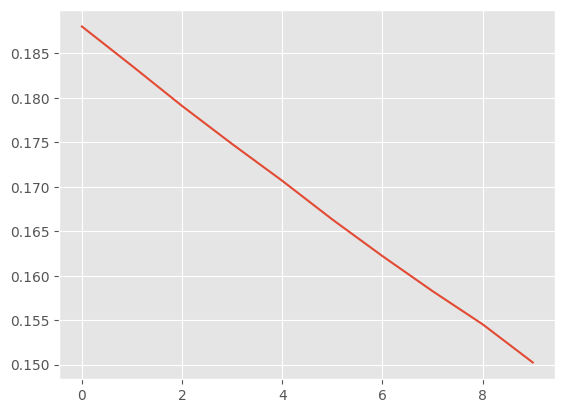

In [431]:
plt.plot(loss_array_j)
plt.show()

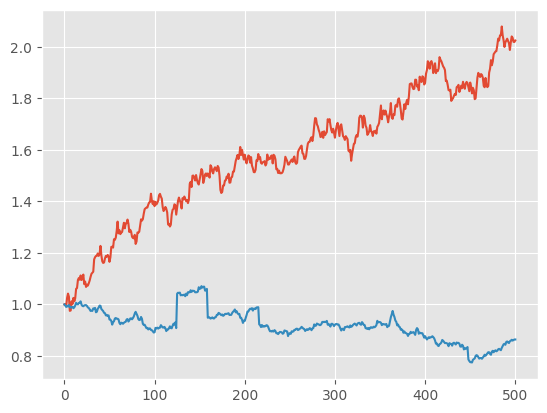

In [435]:
plt.plot(sol.detach().numpy().T)
plt.plot(u[0])
plt.show()

In [201]:
# data_tensor = data_tensor.view(1, -1)

## NSDE

In [204]:
# u = data_tensor
# h_dim = len(u[0])
# time_steps = 50
# dt = torch.FloatTensor([1/time_steps])

# nsde = NSDE(h_dim, dt, time_steps)

# nsde.fit(u, epochs=100)

# s_tilde = nsde.sample(10)


# plt.plot(u.T, color='black')
# plt.plot(s_tilde.T, '--')

# plt.show()

## NSDE VAE

In [25]:
u = data_tensor
h_dim = len(u[0])
data_dim = len(data_tensor[0])
time_steps = 50
dt = torch.FloatTensor([1/time_steps])

set_A = torch.stack(list(map(lambda x: create_setA(x), u)))


h_dim_v = 1
z_dim = 30
data_dim = len(data_tensor[0])

phi = Phi(z_dim, 1, 1)
mu_v = Mu_V(1, h_dim_v, data_dim)
sigma_v = Sigma_V(1, h_dim_v, data_dim)
f = Operator_F(h_dim, h_dim)

optim_phi = optim.Adam(phi.parameters(), lr=3e-4)
optim_mu_v = optim.Adam(mu_v.parameters(), lr=3e-4)
optim_sigma_v = optim.Adam(sigma_v.parameters(), lr=3e-4)
optim_f = optim.Adam(f.parameters(), lr=3e-4)


epochs_v = tqdm(range(100))
loss_array_v = []
mse_v = nn.MSELoss()

In [38]:
for _ in epochs_v:  
    v_array = torch.zeros(size=(u.size(0), h_dim, 1))

    for i in range(u.size(0)):
        u0 = phi(torch.randn(size=(u.size(0), z_dim)), u[:, 0].view(-1, 1))
        v_sol = sdeint_V(mu_v, sigma_v, dt, u0[i], h_dim, h_dim_v, set_A[i])
        v_array[i] = v_sol
        
    v_array = v_array.squeeze(2)
    
    v_array = f(v_array)
    
    
    loss_v = mse_v(v_array, u) + torch.mean((u0 - u[:, 0])**2)
    
    optim_phi.zero_grad()
    optim_mu_v.zero_grad()
    optim_sigma_v.zero_grad()
    optim_f.zero_grad()
    
    loss_v.backward()
    
    optim_phi.step()
    optim_mu_v.step()
    optim_sigma_v.step()
    optim_f.step()
    
    epochs_v.set_description(f'Loss: {loss_v.item()}')
    loss_array_v.append(loss_v.item())

Loss: 0.10696950554847717: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


In [39]:
v_array = torch.zeros(size=(u.size(0), h_dim, 1))

for i in range(u.size(0)):
    u0 = phi(torch.randn(size=(u.size(0), z_dim)), u[:, 0].view(-1, 1))
    v_sol = sdeint_V(mu_v, sigma_v, dt, u0[i], h_dim, h_dim_v, set_A[i])
    v_array[i] = v_sol
    
v_array = v_array.squeeze(2).detach().cpu().numpy()


plt.plot(v_array.T)
plt.plot(u.T, color='black')
plt.show()

In [438]:
nsde_vae = NSDE_VAE(h_dim, time_steps, dt)
# 20*2001 u.size(0) *
loss_array, loss_array_v, logvar_array = nsde_vae.fit(u, set_A, u[:, 0].view(-1, 1), epochs=200)

samples = nsde_vae.sample(13, set_A, u[:, 0].view(-1, 1))[:, 0, :]

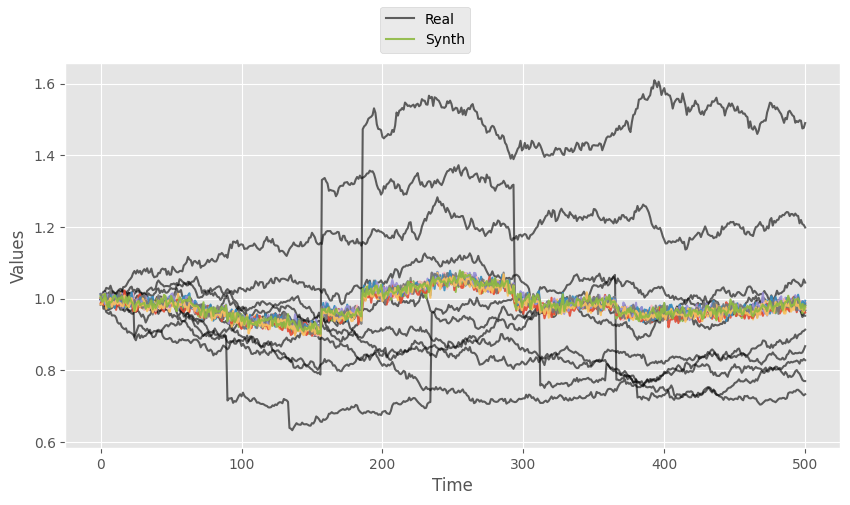

In [488]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(u.T, color='black', alpha=0.6, label='Real')
plt.plot(samples.T, alpha=0.9, label='Synth')

handles, labels = ax.get_legend_handles_labels()
fig.legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc='upper center')

# plt.legend()
plt.ylabel('Values')
plt.xlabel('Time')
plt.show()

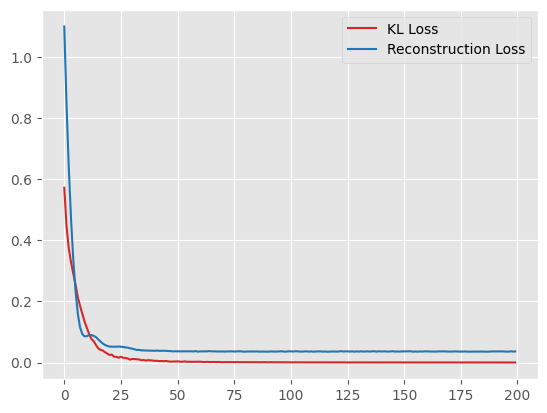

In [492]:
loss_array = np.array(loss_array).T

plt.plot(loss_array[0], color='tab:red', label='KL Loss')
plt.plot(loss_array[1], color='tab:blue', label='Reconstruction Loss')
# plt.plot(loss_array_v, color='green', label='Loss $V(t)$')

plt.legend()
plt.show()